# Continuation of Makemore
This is based on the following paper by [Bengio, et all](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and the lovely YouTube series by Andrej Karpathy

In the last we made a bigram model through counts and a simple 1 layer NN. This time we will be following this paper to make a version of an MLP. 

I will be building out a similar to [this tool](https://github.com/karpathy/makemore/tree/master) from scratch. Note that I will be following the tutorial doing it step by step not looking at the final repo. 

Over all I will work through these papers:
- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

In [20]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

In [21]:
words = open("data/names.txt", "r").read().splitlines()
print(f'Total number of words: {len(words)}')
smallest = min(len(w) for w in words)
largest = max(len(w) for w in words)
print(f'Smallest Word is {smallest} char while the largest is {largest} char')

Total number of words: 32033
Smallest Word is 2 char while the largest is 15 char


In [22]:
# build the covabulary of chars and mappings 
chars = sorted(list(set(''.join(words))))
str_to_ind = {s:i + 1 for i,s in enumerate(chars)}
str_to_ind['.'] = 0
ind_to_str = {i:s for s,i in str_to_ind.items()}
print(ind_to_str)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [23]:
block_size = 3 # this is the n for the n-gram (how big is the window to predict the next)
X, Y = [], []
for word in words[:5]:
    print(word)
    context = [0] * block_size # padded
    for ch in word + '.':
        ind = str_to_ind[ch]
        X.append(context)
        Y.append(ind)
        print(''.join(ind_to_str[i] for i in context), '--->', ind_to_str[ind])
        context = context[1:] + [ind] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [24]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [25]:
C = torch.randn((27, 2))

In [26]:
C[5]

tensor([-1.0268,  0.9244])

In [27]:
C[X].shape

torch.Size([32, 3, 2])

In [28]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [29]:
# this is a way to niavely concact
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape 

torch.Size([32, 6])

In [30]:
# This does the same ast he above but generalized
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [31]:
# it can be more effecient to just get the view though
emb.view(32,6).shape

torch.Size([32, 6])

In [32]:
emb.view(32,6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [33]:
emb.view(32,6).shape == emb.view(-1,6).shape

True

In [34]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [35]:
# Broadcast check
# 32, 100
#  1, 100 
# Looks good

hidden = torch.tanh(emb.view(-1, 6) @ W1 + b1)
hidden

tensor([[-0.0046,  0.5415, -0.8243,  ...,  0.9921, -0.2344, -0.9925],
        [-0.4792,  0.4792, -0.2265,  ...,  1.0000,  0.9998, -0.9969],
        [-0.7441, -0.9761,  0.2758,  ..., -0.9810, -0.7232,  0.9522],
        ...,
        [ 0.9931,  0.9473, -0.8880,  ...,  0.9991, -0.9975, -0.9998],
        [-0.5424,  0.8042, -0.7782,  ...,  1.0000,  1.0000, -0.9988],
        [-0.9131, -0.9947,  0.2924,  ..., -0.9949,  0.4160,  0.9870]])

In [36]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [37]:
logits = hidden @ W2 + b2
logits.shape

torch.Size([32, 27])

In [38]:
# soft max
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)

In [39]:
prob.shape

torch.Size([32, 27])

In [40]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [41]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(25.0965)

In [42]:
# Above is uneffecient and can misbehave numerically. (with high positive number with exp floating point error) Use cross_entropy
# interestingly they get around this by taking the max(logits) and subtracts it from the logits before they are .exp()
F.cross_entropy(logits, Y)

tensor(25.0965)

In [99]:
# ------- re-write cleaner -----------

In [132]:
block_size = 3 # this is the n for the n-gram (how big is the window to predict the next)
X, Y = [], []
for word in words:
    context = [0] * block_size # padded
    for ch in word + '.':
        ind = str_to_ind[ch]
        X.append(context)
        Y.append(ind)
        context = context[1:] + [ind] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [133]:
X.shape, X.dtype, Y.shape, Y.dtype # dataset

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [134]:
total_epochs = 0
g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

In [135]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [144]:
epoch = 10000
#lri = []
#lossi = []
learning_rate = 0.1
for i in range(epoch):
    
    # minibatch contstruct, faster although not exact
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward
    emb = C[X[ix]]                                 # Size([32, 3, 2])
    hidden = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Size([32, 100])
    logits = hidden @ W2 + b2                      # Size([32, 27])
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())

    # backward
    for p in parameters:
        p.grad = None # zero_grade
        
    loss.backward()
    # update
    #learning_rate = lrs[i]
    learning_rate = 0.0001 # for decay
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    # track stats
    total_epochs += 1
    #lri.append(lre[i])
    #lossi.append(loss.item())

emb = C[X]                                    # Size([32, 3, 2])
hidden = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Size([32, 100])
logits = hidden @ W2 + b2                      # Size([32, 27])
total_loss = F.cross_entropy(logits, Y)
total_loss
print(f"total epochs processed: {total_epochs} with total_loss: {total_loss}")

total epochs processed: 63000 with total_loss: 2.3767640590667725


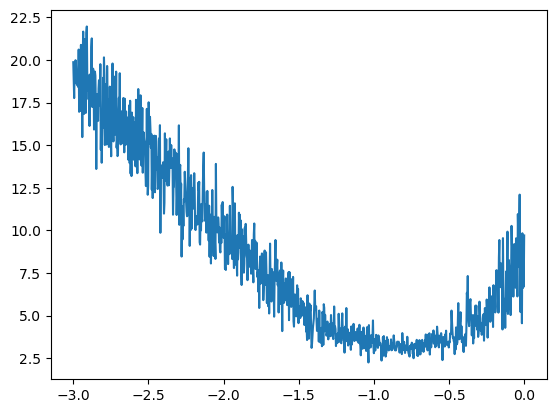

In [131]:
plt.plot(lri, lossi)

This shows 10**-1 or 0.1 wis a good learning rate

# Let's do it again but more respectable

Now let's do it with a train/validation (or dev)/test split of 80/10/10 (you don't want to do test very often this is our most valued)

train - changes your weights
dev - changes your parameters

In [248]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        context = [0] * block_size # padded
        for ch in word + '.':
            ind = str_to_ind[ch]
            X.append(context)
            Y.append(ind)
            context = context[1:] + [ind] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size=4
X_train, Y_train = build_dataset(words[:n1], block_size=4)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=4)
X_test, Y_test = build_dataset(words[n2:], block_size=4)

torch.Size([182484, 4]) torch.Size([182484])
torch.Size([22869, 4]) torch.Size([22869])
torch.Size([22793, 4]) torch.Size([22793])


In [249]:
X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype # dataset

(torch.Size([182484, 4]), torch.int64, torch.Size([182484]), torch.int64)

In [299]:
total_epochs = 0
stepi = []
lossi = []
dimensions = 10
hidden_nodes = 500
input_size = dimensions*block_size
g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((len(str_to_ind), dimensions), generator=g)
W1 = torch.randn((input_size, hidden_nodes), generator=g)
b1 = torch.randn(hidden_nodes, generator=g)
W2 = torch.randn((hidden_nodes,27), generator=g)
b2 = torch.randn(len(str_to_ind), generator=g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

In [303]:
epoch = 200000
learning_rate = 0.1
decay = 0.1
batch_size = 250
decay_threshold = 300000

for i in range(epoch):
    
    # minibatch contstruct, faster although not exact
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    
    # forward
    emb = C[X_train[ix]]                               
    hidden = torch.tanh(emb.view(-1, input_size) @ W1 + b1)      
    logits = hidden @ W2 + b2                            
    loss = F.cross_entropy(logits, Y_train[ix])

    # backward
    for p in parameters:
        p.grad = None # zero_grade
        
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    # track stats
    total_epochs += 1
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    if total_epochs > 0 and total_epochs%decay_threshold == 0:
        learning_rate *= decay
        
    if i % 4000 == 0:
        print(f"epochs number: {total_epochs} with average of last 10 loss: {np.mean(lossi[:-10])}")

print(f"total epochs processed: {total_epochs} with average of last 10 loss: {np.mean(lossi[:-10])}")

epochs number: 200001 with average of last 10 loss: 0.3596505278926547
epochs number: 204001 with average of last 10 loss: 0.35910193704050364
epochs number: 208001 with average of last 10 loss: 0.3585584316508151
epochs number: 212001 with average of last 10 loss: 0.3580352253751669
epochs number: 216001 with average of last 10 loss: 0.3575246383639531
epochs number: 220001 with average of last 10 loss: 0.3570147976106872
epochs number: 224001 with average of last 10 loss: 0.35651508827634937
epochs number: 228001 with average of last 10 loss: 0.35602032975270925
epochs number: 232001 with average of last 10 loss: 0.3555517400210463
epochs number: 236001 with average of last 10 loss: 0.35509204275214323
epochs number: 240001 with average of last 10 loss: 0.3546284690526191
epochs number: 244001 with average of last 10 loss: 0.35417790555050493
epochs number: 248001 with average of last 10 loss: 0.3537460590468482
epochs number: 252001 with average of last 10 loss: 0.3533099020726336
e

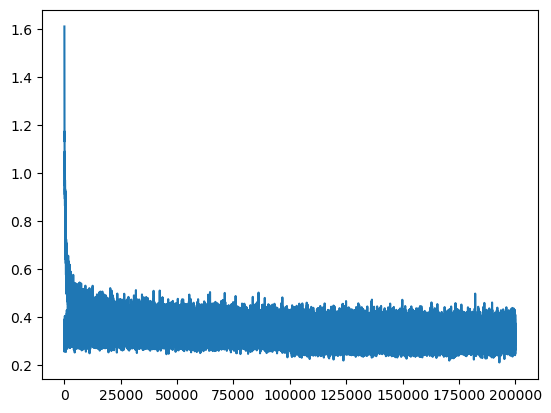

In [304]:
plt.plot(stepi, lossi)

In [305]:
# evaluate train loss
emb = C[X_train]                                 # Size([32, 3, 2])
hidden = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # Size([32, 100])
logits = hidden @ W2 + b2                      # Size([32, 27])
train_loss = F.cross_entropy(logits, Y_train)
print(f"total epochs processed: {total_epochs} with dev_loss: {train_loss}")

total epochs processed: 400000 with dev_loss: 1.9698072671890259


In [306]:
# Evaluate parameters
emb = C[X_dev]                                 # Size([32, 3, 2])
hidden = torch.tanh(emb.view(-1,input_size) @ W1 + b1) # Size([32, 100])
logits = hidden @ W2 + b2                      # Size([32, 27])
dev_loss = F.cross_entropy(logits, Y_dev)
dev_loss
print(f"total epochs processed: {total_epochs} with dev_loss: {dev_loss}")

total epochs processed: 400000 with dev_loss: 2.0916128158569336


------------------------

When running this through 50,000 times for a train_loss of 2.37 and a dev_loss of 2.335 we see that we are underfitting (these two are much the same). We went back to adjust make a bigger network to address this by bumping up the hidden layer (tanh) to 300.

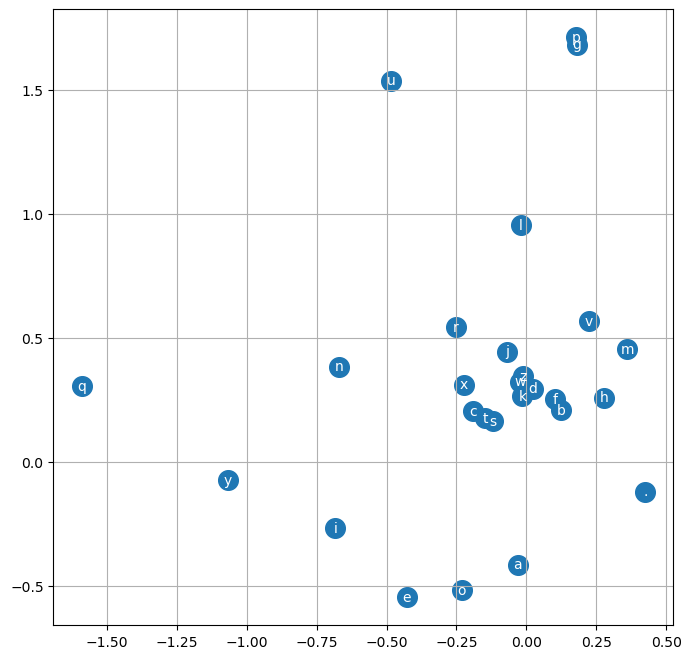

In [173]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), ind_to_str[i], ha="center", va="center", color="white")
plt.grid('minor')

This gives an idea of the embedding space after all this. There is still a bottle neck to the network though. We will go ahead an change the embeddings but it won't be good to visualize like it was above

The best he had after 30 min was 2.17 on dev_loss let's see if we can get better. 

Here are some knobs:
1. Number of nuerons in the model
2. The dimensionality of the lookup table
3. Change the number of characters fed in (block_size)
4. Learning rate
5. Decays
6. Batch Size could improve the speed

I got to 2.15 just by having hte learning reate decay every 100000 by a factor of 10 and running it 400000 times. Next I'm trying to move to a 4 block size instead. 

That got the dev block to 2.14 and the test to 2.17. Interesting! This was only in 200000. So this diverged a bit. Sounds like I'm over fitting. Let's move the batch size up to 50. This let it converge faster so train went down to 2.09 and dev loss to 2.13. Let's run it for 200,000 more. That knocked it down to 2.04 and 2.10 so let's increase the batch size to 150. At 800000 epocs we are still going down. Maybe it needs more batch size to converge quicker?  A 1,000,000 we have 1.98 and 2.07 respecitively. This is still going down together though...

Let's up the batch size to 250 and start over let's also not decrease the learning rate until every 300000 as it's really steady. At 200000 we are already doing better with 2.09, 2.14. From teh graph we can see it's starting to trend down but not quickly. 

Let's up the neurons to a bigger network. 500 to play. After 200000 it's at 2.08 and 2.14. So I'm not sure it actually made much of a difference. After 400000 it has lowered to 1.9 and 2.09. 

I think I'm happy with this for now. What's the actual test data say?

## Test Data

In [308]:
# Evaluate parameters
emb = C[X_test]                                # Size([32, 3, 2])
hidden = torch.tanh(emb.view(-1,input_size) @ W1 + b1) # Size([32, 100])
logits = hidden @ W2 + b2                      # Size([32, 27])
test_loss = F.cross_entropy(logits, Y_test)
print(f"total epochs processed: {total_epochs} with dev_loss: {test_loss}")

total epochs processed: 400000 with dev_loss: 2.102531909942627


## Sampling

In [311]:
g = torch.Generator().manual_seed(2147483647 + 10) # reproducibility 

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]                       # Size([1, block_size, d])
        hidden = torch.tanh(emb.view(-1,input_size) @ W1 + b1) 
        logits = hidden @ W2 + b2             
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(ind_to_str[i] for i in out))

carmah.
amelle.
khi.
milia.
atlankanden.
jazhurn.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
hamondin.
quint.
shoilyn.
jadbi.
wazelyn.
jaryn.
kalyse.
dusa.
mestice.
